# Linear Regression

The goal of regression is to learn a mapping from given input data x to output y: $y(\mathbf{x})=\mathbf{w}^T \mathbf{x}+\epsilon$, where $\mathbf{x}$ is the input vector, $\mathbf{w}$ the weight vector and $\epsilon$ the residual error of the prediction.


### Linear Regression using polynomial and gaussian kernels

Necessary imports and reading data:

In [9]:
import numpy as np
from utils.utils import read_data_from_txt
import view.visualize_curves as v



path_data="data/part2/linRegData.txt"

data=read_data_from_txt(path_data,dim=(-1,2))
train,test=data[:20],data[20:]
X_train,Y_train=train[:,0],train[:,1]
X_test,Y_test=test[:,0],test[:,1]


The root mean squared error (RMSE) is defined as: $RMSE=\sqrt{\frac{\sum^N_{i=1}(\hat{y}_i-y_i)^2}{N}}$ where $\hat{y_t}$ are the predicted values, $y_t$ the true values and $N$ the number of examples.

In [2]:
def compute_rmse(Y, Y_pred):
    '''
    Computing the RMSE (root mean squared error) of given true Y and predicted Y

    :param Y: true labels
    :param Y_pred: predicted labels
    :return: RMSE
    '''
    return np.sqrt(np.sum((Y-Y_pred)**2)/len(Y))

The weights $\mathbf{w}$ are computed by finding the least squares solution:<br> $\mathbf{w}=\mathrm{argmin}_{\mathbf{w}}|| \mathbf{\hat{X}}^T\mathbf{w}-\mathbf{y}||^2$.<br>
Now we write the equation for the derivative with respect to $w$ and set it to zero: $\nabla_{\mathbf{w}}||\mathbf{\hat{X}}^T\mathbf{w}-\mathbf{y}||^2=0$ and obtain the  ordinary least squares (OLS) equation: $\mathbf{\hat{w}}=(\mathbf{\hat{X}}\mathbf{\hat{X}}^T)^{-1}\mathbf{\hat{X}}\mathbf{y}$

In [3]:
def compute_params_by_least_squares(X_rewr, Y,gamma=None):
    '''
    Computing the parameters of the polynom by least squares method

    :param X_rewr:
    :param Y: labels
    :param gamma: not used, just to comply with the signature
    :return: parameters
    '''
    return np.dot(np.dot(np.linalg.inv(np.dot(X_rewr.T, X_rewr)), X_rewr.T), Y)

To avoid overfitting and instabilities we can extend the previous least square equation by a regularization term, in this case ridge-regularization: $\mathbf{w}=\mathrm{argmin}_{\mathbf{w}}|| \mathbf{\hat{X}}^T\mathbf{w}-\mathbf{y}||^2+\frac{\gamma}{2}||\mathbf{w}||^2$.<br>
Solving again for $\hat{w}$ we obtain the new regularized estimate $\mathbf{\hat{w}}=(\mathbf{\hat{X}}\mathbf{\hat{X}}^T+\gamma I)^{-1}\mathbf{\hat{X}}\mathbf{y}$.

In [4]:
def compute_params_by_regul_least_squares(X_rewr, Y,gamma):
    '''
    Computing the parameters of the polynom by regularized least squares method

    :param X_rewr: rewritten X e.g. polynomial or gaussian basis function applied to X
    :param Y: labels
    :return: parameters
    '''
    return np.dot(np.dot(np.linalg.inv(np.dot(X_rewr.T, X_rewr)
                +np.array(np.dot(gamma,np.identity(X_rewr.shape[1],dtype=np.float32)),dtype=np.float32)), X_rewr.T), Y)



To use the polynomial basis function as kernel we have to rewrite the input data $X$. For example, the vector of a polynomial basis function of degree 3 (cubic polynom) is $\phi(x)=(1,x,x^2,x^3)$:

In [5]:
def compute_polynomial_basis_fn(X, n_features,sigma=None):
    '''
    Rewriting input data X to a polynom of a specified degree.
    For degree=3 and feature-length=2 the polynom has the form y=w0+w1*x1+w2*x2+w3*x1^2+w4*x2^2

      :param X: input data
      :param n_features: degree of the polynom
      :param sigma: not used, just to comply with the signature of a basis-fn
      :return:
    '''
    # define rewritten X by adding value 1 to each data point vector to consider constant w0 in the polynomial equation
    stacked=np.array([X ** i for i in range(n_features + 1)])
    if stacked.shape[0]>1:
        stacked=np.stack(stacked,axis=1)

    return stacked

Defining gaussian function:

In [12]:
def gaussian_fn(X,mu,sigma):
    '''
    Computing the gaussian pdf

    :param X: input
    :param mu: mean
    :param sigma: variance
    :return: pdf
    '''
    return np.exp(-(X-mu)**2/(2*sigma))

The gaussian basis function as kernel transforms each data point in $X$ into a predefined number of gaussians. Here we use means, which are distributed linearly in \[0,2\] and with variance $\sigma^2=0.02$. For each feature $j$ of a data point x we compute $\phi_j(x)=e^{-\frac{(x-\mu_j)^2}{2\sigma^2}}$

In [6]:
def compute_gaussian_basis_fn(X, n_features,sigma=None):
    '''
    Using gaussian as basis function

    :param X: data input
    :param n_features: number of gaussian basis fn.
    :param sigma: predefined variance
    :return:
    '''
    # create n_features means distributed linearly
    mu_arr = np.linspace(X.min(), X.max(), n_features+1)
    if sigma is None:
        sigma=(mu_arr[1]-mu_arr[0])

    # define rewritten X by adding value 1 to each data point vector to consider constant w0 in the polynomial equation
    stacked = np.array([gaussian_fn(X,mu,sigma) for mu in mu_arr])
    # normalizing features by summing each x to 1
    norm_map=map(lambda x: x/np.sum(x),np.stack(stacked,1))
    # rearrange matrix after normalizing
    stacked=np.stack(np.array(list(norm_map)),1)
    if stacked.shape[0] > 1:
        stacked = np.stack(stacked, axis=1)

    return stacked

We predict the output by computing $y(\mathbf{x})=\mathbf{w}^T\phi(\mathbf{x}))$, where $\phi$ is the basis function and $w$ the weights:

In [7]:
def predict(X_rewr,w_rewr):
    '''
    Predicting labels by rewritten X and the corresponding parameters

    :param X_rewr: rewritten input X (matrix)
    :param w_rewr: rewritten parameters w (vector)
    :return: vector with the predicted labels
    '''
    return np.array(np.dot(X_rewr,w_rewr),dtype=np.float32)

Function to find prediction with least RMSE by trying different polynomial degrees or different gaussian functions, depending on the basis function:

In [10]:
def linear_regression(X_train,Y_train,X_test,Y_test,n_features,basis_fn,sigma=None,gamma=None):
    '''
    Linear regression using polynomial or gaussian basis function as kernel and regularization with ridge coeff.

    :param X_train: training input data
    :param Y_train: testing input data
    :param X_test: testing output data
    :param Y_test: testing output data
    :param n_features: degree of the polynomial or number of gaussians
    :param basis_fn: polynomial or gaussian
    :param sigma: used for gaussian basis function
    :param gamma: ridge-coefficient for regularization
    :return: predictions and corresponding RMSEs
    '''
    rmse_min=None
    rmse_vals=[]
    # if gamma-coefficient for ridge regression is passed, then use the respective fn.
    compute_params=compute_params_by_regul_least_squares if gamma else compute_params_by_least_squares
    Y_best=None
    # computing the RMSE and output prediction with test data as input and for polynomial degrees/number of gaussian from 1 to 21
    for exp in range(1,n_features):
        # apply basis function to rewrite X for training and testing input data
        X_rewr_train = basis_fn(X=X_train,n_features=exp,sigma=sigma)
        X_rewr_test = basis_fn(X=X_test,n_features=exp,sigma=sigma)

        # compute parameters using training data
        w_rewr = compute_params(X_rewr_train, Y_train,gamma)
        # predict output using testing data and parameters
        y_pred = predict(X_rewr_test, w_rewr)

        # compute RMSE
        rmse_v = compute_rmse(Y_test, y_pred)


        rmse_vals.append(rmse_v)

        # determine best output predictions depending on the lowest RMSE
        if rmse_min is None:
            rmse_min = rmse_v
            Y_best = y_pred

        elif rmse_v < rmse_min:
            rmse_min = rmse_v
            Y_best = y_pred

    return Y_best,rmse_vals

Apply linear regression with different settings: polynomial or gaussian basis functions and with/without ridge regularization:

In [13]:

max_n_features=22
# gaussian basis fn. + ridge regularization
gauss_ridge_Y_best,gauss_ridge_rmse = linear_regression(X_train,Y_train,X_test,Y_test,n_features=max_n_features,basis_fn=compute_gaussian_basis_fn,sigma=np.sqrt(0.02),gamma=10**-6)

# gaussian basis fn. + no regularization
gauss_Y_best,gauss_rmse = linear_regression(X_train,Y_train,X_test,Y_test,n_features=max_n_features,basis_fn=compute_gaussian_basis_fn,sigma=np.sqrt(0.02),gamma=None)

# polynomial basis fn. + no regularization
polyn_Y_best,polyn_rmse = linear_regression(X_train,Y_train,X_test,Y_test,n_features=max_n_features,basis_fn=compute_polynomial_basis_fn,sigma=np.sqrt(0.02),gamma=None)

# polynomial basis fn. + ridge regularization
polyn_ridge_Y_best,polyn_ridge_rmse = linear_regression(X_train,Y_train,X_test,Y_test,n_features=max_n_features,basis_fn=compute_polynomial_basis_fn,sigma=np.sqrt(0.02),gamma=10**-6)



Plotting linear regression predictions and corresponding root mean squared error (RMSE):

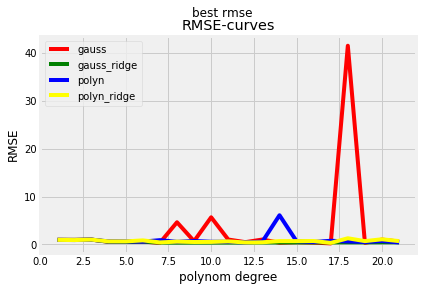

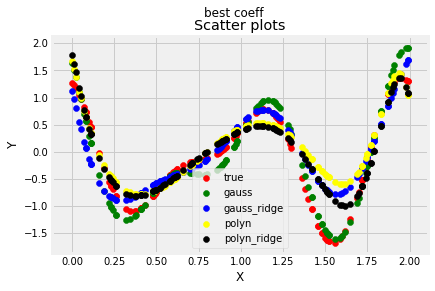

In [14]:

def plot_rmse(X,fig_title,fig_subtitle,**args):
    colors = ["red", "green", "blue", "yellow", "black", "gray"]
    if type(list(args.values())[0]) is dict:
        args = list(args.values())[0]
    for (k, v), c in zip(args.items(), colors):
        plt.plot(X, v, c=c, label=k)
    plt.suptitle(fig_subtitle)
    plt.title(fig_title)
    plt.xlabel("polynom degree")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

def plot_multiple_curves(X,fig_title,fig_subtitle,**args):
    colors=["red","green","blue","yellow","black","gray"]
    if type(list(args.values())[0]) is dict:
        args=list(args.values())[0]
    for (k,v),c in zip(args.items(),colors):
        plt.scatter(X, v, c=c, label=k)
    plt.suptitle(fig_subtitle)
    plt.title(fig_title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

    
# plot RMSE curves
v.plot_rmse(np.arange(1,max_n_features),fig_title="RMSE-curves",fig_subtitle="best rmse",gauss=gauss_rmse,gauss_ridge=gauss_ridge_rmse,
            polyn=polyn_rmse,polyn_ridge=polyn_ridge_rmse)

# plot predictions using different settings
v.plot_multiple_curves(X_test,fig_title="Scatter plots",fig_subtitle="best coeff",true=Y_test,gauss=gauss_Y_best,gauss_ridge=gauss_ridge_Y_best,
            polyn=polyn_Y_best,polyn_ridge=polyn_ridge_Y_best)

### Bayesian Linear Regression

To compute the weights $\theta$ we need to compute the covariance matrix $\Sigma=\alpha I+\beta \Phi\Phi^T$ before, where $\Phi$ is the basis function, $\beta$ the gaussian noise and $\alpha I$ the spherical covariance matrix of the prior.

In [15]:
def compute_cov_bayes_regr(X,alpha,beta):
    '''
    Computing the covariance matrix

    :param X: input data
    :param alpha: prior coefficient
    :param beta: gaussian noise
    :return:
    '''
    dim=X.shape[1] if len(X.shape)>1 else 1

    return alpha*np.identity(dim)+beta*np.dot(X.T,X)


Now we can compute the weights $\theta=(\frac{1}{\beta}\Sigma)^{-1}\Phi{y}=(\frac{\alpha}{\beta} I+\Phi\Phi^T)^{-1}\Phi{y}$, where $\gamma=\frac{\alpha}{\beta}$ is the ridge coefficient, $y$ the output vector of the training data:

In [16]:
def compute_weights_bayes_regr(X, Y, cov, beta):
    '''
    Computing weights/parameters

    :param X: data input
    :param Y: data output / labels
    :param cov: covariance matrix
    :param beta: gaussian noise
    :return: weight
    '''
    dim = X.shape[1] if len(X.shape) > 1 else 1

    eq1 = np.dot(np.dot(np.linalg.inv(1 / beta * cov), X.reshape([-1, dim]).T), Y)

    return eq1


The predictive distribution is defined as $p(y_{*}|\mathbf{x}_{*},\mathbf{X},\mathbf{y})=\int p(y_{*}|\mathbf{x}_{*},\theta) p(\theta|\mathbf{X},\mathbf{y}) d\theta$, where the first term is the likilihood and the second term the parameter posterior.<br><br>
The predictive distribution of input data $\mathbf{x}_{*}$ is also a gaussian:<br> 
$p(y_{*}|\mathbf{x}_{*},\mathbf{X},\mathbf{y})=\mathcal{N}(y_{*}|\mu(\mathbf{x}_{*}),\sigma^2(\mathbf{x}_{*}))$ <br>

Prediction with bayes is done by computing the mean $\mu(\mathbf{x}_*)=\phi^T(\mathbf{x}_*) \theta$, where $\mathbf{x}_*$ is a data point from the test data. To obtain the variance $\sigma^2$ we need to compute $\sigma^2(\mathbf{x}_{*})=\frac{1}{\beta}+\Sigma^{-1}\phi(\mathbf{x}_{*})$

In [17]:
def predict_bayes_regr(X,Y,cov,weights,beta):
    '''

    :param X: input data
    :param Y:  output data
    :param cov: covariance matrix
    :param weights: weights/parameters
    :param beta: gaussian noise
    :return: predicted output: mean, variance and probability
    '''
    dim=X.shape[1] if len(X.shape)>1 else 1

    # predicting the mean values
    mu = np.dot(X.reshape([-1,dim]), weights.reshape(-1,dim).T)
    # predicting the variances
    sigma=np.array([1/beta  + np.dot(np.dot(x.reshape([-1,1]).T, np.linalg.inv(cov)),x.reshape([-1,1])) for x in X]).ravel()
    # predicting the probality that the predicted mean correspond to the true value
    prob= np.array([gaussian_fn(y,mu=mu1,sigma=sigma1) for y,mu1,sigma1 in zip(Y,mu,sigma)]).ravel()

    return mu,sigma,prob

Creating subplots of bayes linear regression where each subplot contains the curve of the full data, the curve with :

In [20]:
def create_subplot_predictive_distributions_uncertainty(data_true_full, data_true_partly, data_pred, std_err, fig_subtitle, ax):
    colors=["red","green","blue","yellow","black","gray"]
    data_true_full=np.array(sorted(data_true_full,key=lambda x: x[0]))
    #for (k,tup),c in zip(data_true_full,colors):
    ax.plot(data_true_full[:,0], data_true_full[:,1], c=colors[0], label="true data")
    ax.scatter(data_true_partly[0,:], data_true_partly[1,:], c=colors[1],label="partly data")
    ax.plot(data_pred[0,:], data_pred[1,:], c=colors[2], label="pred data")
    ax.fill_between(data_pred[0,:], data_pred[1,:]-std_err,data_pred[1,:]+std_err,label="pred data")
    ax.set_title(fig_subtitle,fontsize="medium")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

Applying bayes linear regression using different number of training data and plotting them. The parameters are chosen as $\gamma=10^{-6}$ (ridge coefficient), $\alpha=0.00039$ (prior coefficient) and $\beta=\gamma\alpha=400.0$ (gaussian noise).<br>
$\alpha I$ is the spherical covariance matrix of the prior.

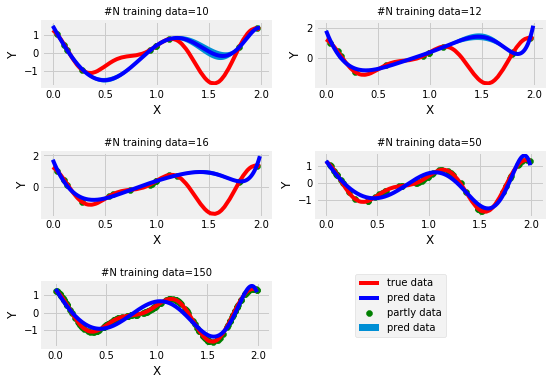

In [23]:
def bayes_linear_regression(data):
    '''
    Predict mean values and standard error using different numbers of training data and plot them

    :param data: full data
    :return:
    '''
    import matplotlib.pyplot as plt
    import math
    n_data=[10, 12, 16, 50, 150]

    ncols=2

    nrows=math.ceil(len(n_data)/ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(8,6))
    plt.subplots_adjust(hspace=1.0)
    for i,n in enumerate(n_data):
        # use n number of training data
        X_train=data[:n,0]
        Y_train=data[:n,1]
        # create input data withing X=[0,2] to predict output
        X=np.arange(2,step=0.01)

        # rewriting input data for training and testing using polynomial basis function of degree 10
        X_rewr_random=compute_polynomial_basis_fn(X, 10)
        X_rewr_train=compute_polynomial_basis_fn(X_train, 10)

        # ridge-coeff=alpha/beta
        ridge_coeff=10**-6
        # gaussian noise
        beta=1/0.0025
        # alpha is prior precision
        alpha=beta*ridge_coeff

        # compute covariance matrix
        cov=compute_cov_bayes_regr(X_rewr_train,alpha=alpha,beta=beta)
        # compute weights using training data
        weights=compute_weights_bayes_regr(X_rewr_train,Y_train,cov,beta=beta)

        # predict mean, variance and probability
        y_pred_bayes,sigma_bayes,prob_bayes=predict_bayes_regr(X_rewr_random,Y_test,cov,weights,beta=beta)
        # computing standard error from the variance
        std_bayes=np.sqrt(sigma_bayes)

        # compute current row and column index of the subplot
        row_idx=int(abs(i/ncols))
        col_idx=i%2

        # create a subplot using the prediction and original data
        create_subplot_predictive_distributions_uncertainty(data_true_full=data,
                                                              data_true_partly=np.stack([X_train,Y_train]),
                                                              data_pred=np.stack([X,y_pred_bayes.ravel()]), std_err=std_bayes,
                                                              fig_subtitle="#N training data="+str(n),
                                                              ax=ax[row_idx,col_idx])

    # compute index of last row and column to delete it
    row_idx=int(abs(len(n_data)/ncols))
    col_idx=len(n_data)%2
    # delete last odd axis to put the legend there
    fig.delaxes(ax[row_idx,col_idx])

    # apply legend and plot
    plt.legend(loc="best",bbox_to_anchor=(1.35, 1.2))
    plt.show()

bayes_linear_regression(data=data)